In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

C:\Users\USER\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


In [9]:
dataset = np.loadtxt("DataNN_formatted.csv", delimiter=",")
# split into input (X) and output (Y) variables
train_data = dataset[:,0:16]
train_labels = dataset[:,16]

In [12]:
print("Training set: {}".format(train_data.shape))  # 9 examples, 16 features
# print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features

Training set: (9, 16)


In [13]:
print(train_data[0])  # Display sample features, notice the different scales

[0.000e+00 1.000e+00 5.900e+01 2.540e+01 2.692e+00 3.300e-01 8.220e+00
 3.443e+01 5.800e-01 2.685e+00 2.490e+01 9.700e+00 3.425e+03 1.898e+03
 2.800e-01 5.900e+00]


In [18]:
import pandas as pd

column_names = ['Compressive Strength MPa', 'Aggregate Crushing Value', 'Specific Gravity', 'Water Absorption', 'Point Load', 'Brittleness Value', 'Siever J (SJ) Value', 'Density', 'Location',
                'Dynamic Young Modulus', 'Dynamic Shear Modulus', 'P – Wave Velocity (m/s)', 'S – Wave Velocity (m/s)', 'Poission’s Ratio (V)'
               'Rock Hardness (f)', 'Drilling Rate Index (DRI)'], 

# df = pd.DataFrame(train_data, columns=column_names)
df = pd.DataFrame(train_data)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,1.0,59.0,25.4,2.692,0.33,8.22,34.43,0.58,2.685,24.9,9.7,3425.0,1898.0,0.28,5.90
1,0.0,1.0,126.6,25.1,2.649,0.38,6.75,49.78,0.67,2.710,42.1,16.4,4536.0,2486.0,0.29,12.66
2,1.0,2.0,124.5,27.8,2.691,0.34,7.65,78.23,0.67,2.863,25.0,10.3,3251.0,1969.0,0.21,12.45
3,1.0,0.0,91.7,31.2,2.641,0.33,5.60,81.54,0.70,2.734,16.7,7.0,2641.0,1637.0,0.19,9.17
4,1.0,0.0,174.4,20.2,2.661,0.32,8.51,55.41,0.67,2.758,47.7,18.1,5045.0,2618.0,0.32,17.44


In [19]:
print(train_labels[0:10])

[22. 35. 59. 65. 38. 45. 52. 44. 47.]


## Normalize features¶
It's recommended to normalize features that use different scales and ranges. For each feature, subtract the mean of the feature and divide by the standard deviation:

In [21]:
# Test data is *not* used when calculating the mean and std
test_data = train_data

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])  # First training sample, normalized

[-1.87082869 -0.52128604 -1.0496751  -0.23553942  0.94001739  0.22454436
  0.71772342 -2.02990742 -1.69371093 -0.61261274 -0.99453877 -1.10927349
 -0.75672197 -1.10328381  0.51812776 -1.0496751 ]


Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model more dependent on the choice of units used in the input.

## Create the model
Let's build our model. Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [22]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,313
Trainable params: 5,313
Non-trainable params: 0
_________________________________________________________________


## Train the model¶
The model is trained for 500 epochs, and record the training and validation accuracy in the history object.

In [23]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Visualize the model's training progress using the stats stored in the history object. We want to use this data to determine how long to train before the model stops making progress.

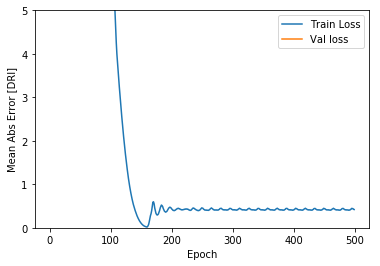

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [DRI]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])

plot_history(history)


This graph shows little improvement in the model after about 200 epochs. Let's update the model.fit method to automatically stop training when the validation score doesn't improve. We'll use a callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.


....................................................................................................
.......................................................

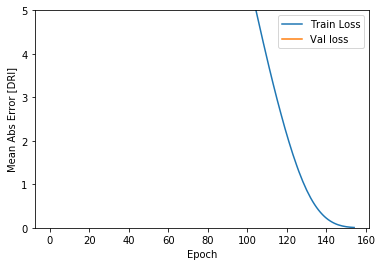

In [27]:

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

The graph shows the average error is about xx. Is this good? Well, xx is not an insignificant amount when some of the labels are only yy.

Let's see how did the model performs on the test set:

In [30]:
test_labels = train_labels
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:7.2f}".format(mae))

Testing set Mean Abs Error:    5.95


## Predict

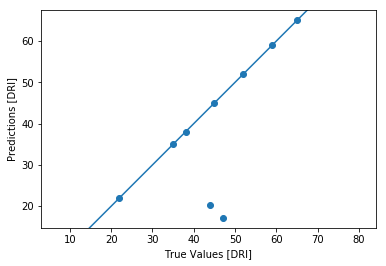

In [31]:

test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [DRI]')
plt.ylabel('Predictions [DRI]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

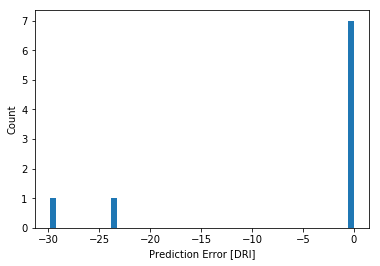

In [32]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [DRI]")
_ = plt.ylabel("Count")


## Conclusion
This notebook introduced a few techniques to handle a regression problem.

Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).
Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
When input data features have values with different ranges, each feature should be scaled independently.
If there is not much training data, prefer a small network with few hidden layers to avoid overfitting.
Early stopping is a useful technique to prevent overfitting.